# ParkMagic! 
### An Example Student Final Project for IST256

### By Michael Fudge

- Students are asked to create something useful with what they learned in the course
- This is usually some kind of data storytelling / app prototype / or both!
- What makes this an "A" grade?
  - incorporate what was learned in the course 
  - clearly demonstrate what the student learned on their own (4 things, here)
  - has well documented code 
  - has modular code with functions, comments, and tests for each function
  - Code tells a story / proves a concept
  - Clearly outlines the section to execute to run the final program
  - Close to 200 lines.

## Syracuse Park magic

- Will you get a parking ticket? We hope not!
- Data courtsey of Syracuse Open Data (https://data.syr.gov/)

## New Stuff I Learned on my own:

- Using the seaborn library for plots: https://seaborn.pydata.org/
- Haversine for distance calculations: https://pypi.org/project/haversine/
- Folium Custom Icons https://ocefpaf.github.io/python4oceanographers/blog/2015/11/02/icons/
- Custom Data set from Syracuse Open Data Portal

## Analysis

### Inputs

Enter a location, day and time (hour) you want to park

### Outputs

I will let you know your chances of getting a ticket (based on the data) and show tickets within a block or so of the location.

That way you can decide if you should pay for parking or not!

### Algorithms

Creating the final dataset

1. Load in the Syracuse Parking data
2. figure out the day of the week / hour of the day for the ticket
3. geocode the location to a lat/lon so it can be mapped
4. save the dataset


Calculating the probabilities

1. for the finalized dataset:
2. create a table of probabilities of getting a parking ticket on day of week X
3. do the same for hour of the day 


Main Alogirithm

1. load final dataset
2. get probabilities for day and hour from dataset
3. get inputs: location, day of week, and hour of day
4. geocode the input location, place it on the map
5. determine if input day is > average for that day
6. determine if input hour is > average for that hour
7. find parking tickets within a block (0.1 of a mile)
8. display chances of getting a ticket
9. display the map of parking tickets

In [1]:
%pip install -q haversine

Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.display import display, HTML, Image
from ipywidgets import interact_manual
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime
from time import sleep
import seaborn as sns
import folium
from haversine import haversine, Unit


## Creating Final Dataset

This section generates the final dataset `final_cuse_parking_violations.csv` from the source data `Parking_Violations_2023.csv` which was downloaded from the Syracuse Open Data Portal (https://data.syr.gov/)

In [3]:
# read in the parking violations original dataset
pv = pd.read_csv("Parking_Violations_2023.csv")

In [21]:
pv.sample(10)

,X,Y,OBJECTID,ticket_number,issued_date,location,description,status,amount
3887,NaN,NaN,3888,391149D,2023/01/18 06:15:00+00,300 GREENWAY AVE,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Fourth Notice,60
22,-8.473641e+06,5.316562e+06,23,369480D,2023/01/01 20:23:00+00,200 KENSINGTON RD,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Paid In Full,60
4984,NaN,NaN,4985,230900520,2023/01/27 10:02:00+00,200 SALINA ST S,UNINSPECTED/ ALL TIMES VTL 306-B,Paid In Full,25
3357,-8.477268e+06,5.322256e+06,3358,388071D,2023/01/19 00:20:00+00,627 CARBON ST,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Paid In Full,60
5274,NaN,NaN,5275,230100168,2023/01/30 16:28:00+00,900 WALNUT AVE,NO STPNG HERE TO CNR/ALL CO15-316(A)6,Paid In Full,25
1903,NaN,NaN,1904,394892D,2023/01/11 08:30:00+00,200 PARK ST,NONE/ONE LICENSE PLATE/ALL VTL402-1,Issued,25
3611,-8.477575e+06,5.313402e+06,3612,396804D,2023/01/15 05:01:00+00,300 SHIRLEY DR,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Adjudication Denied,60
2367,NaN,NaN,2368,231500368,2023/01/14 19:06:00+00,600 WALNUT AVE,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Paid In Full,60
9357,NaN,NaN,9358,230900732,2023/02/21 10:21:00+00,200 WASHINGTON ST W,NO STOPPING ANY TIME CO15-316 (A)14,Third Notice,25
9541,NaN,NaN,9542,230900753,2023/02/22 10:15:00+00,200 JEFFERSON ST W,HANDICAP PRKNG ON-STR /ALL VTL1203(B)2,Adjudication Pending,100


In [13]:
from datetime import datetime
def get_day_of_week(datestring):
    '''
    This function returns the day of the week (Monday, Tuesday, etc..) 
    for an input date string in the format:
    YYYY/MM/DD HH:MM:SS+00
    '''
    dow = datetime.strptime(datestring, "%Y/%m/%d %H:%M:%S+00").strftime("%A")
    return dow

assert get_day_of_week("2023/11/27 14:30:00+00")  == "Monday"

In [19]:
def get_hour_of_day(datestring):
    '''
    This function returns the hour of the day (01, 23, etc..) 
    for an input date string in the format:
    YYYY/MM/DD HH:MM:SS+00
    '''    
    hod = datetime.strptime(datestring, "%Y/%m/%d %H:%M:%S+00").strftime("%H")
    return hod

assert get_hour_of_day("2023/11/27 14:30:00+00") == "14"

In [16]:
# Engineer dayofweek and hourofday columns we will need
pv['dayofweek'] = pv['issued_date'].apply(lambda dt: get_day_of_week(dt))
pv['hour'] = pv['issued_date'].apply(lambda dt: get_hour_of_day(dt))

In [5]:
pv.sample(10)

,Unnamed: 0,X,Y,OBJECTID,ticket_number,issued_date,location,description,status,amount,dayofweek,hour,coords
5953,5953,NaN,NaN,5954,371218D,2023/01/26 09:49:00+00,400 NORTH AVE,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Fourth Notice,60,Thursday,9,"('43.0765049', '-76.1042749')"
15746,15746,NaN,NaN,15747,359705D,2023/07/07 19:03:00+00,1000 EILEEN COLLINS BLVD,NO PARKING ANY TIME CO15-316 (A)14,Paid In Full,25,Friday,19,"(43.113505702811246, -76.11989651004016)"
8564,8564,NaN,NaN,8565,23501032,2023/02/14 11:34:00+00,200 THORNDON PARK,LIMITED PARKING ONLY/ALL TIMES CO15-365,Third Notice,25,Tuesday,11,"(0, 0)"
8037,8037,NaN,NaN,8038,415721D,2023/02/07 01:56:00+00,100 KELLOGG ST,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Third Notice,60,Tuesday,1,"('43.040437', '-76.161953')"
692,692,NaN,NaN,693,231500122,2023/01/06 10:14:00+00,200 WATER ST E,NO STOPPING ANY TIME CO15-316 (A)14,Paid In Full,25,Friday,10,"('43.050425', '-76.150598')"
7323,7323,NaN,NaN,7324,395159D,2023/02/02 13:19:00+00,900 OAK ST,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Third Notice,60,Thursday,13,"('43.0644918', '-76.1359515')"
4279,4279,-8.474522e+06,5.317471e+06,4280,23500462,2023/01/24 12:11:00+00,300 EUCLID AVE,NO PARKING ANY TIME CO15-316 (A)14,Paid In Full,25,Tuesday,12,"('43.0361102', '-76.1278732')"
8928,8928,NaN,NaN,8929,395048D,2023/02/16 11:17:00+00,200 BEAR ST,UNREGSTRD/UNAFFIXD/ALL VTL401-1/403-1,Paid In Full,25,Thursday,11,"('43.067509', '-76.16278')"
11804,11804,NaN,NaN,11805,362608D,2023/02/25 05:00:00+00,100 MARKLAND AVE,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Paid In Full,60,Saturday,5,"('43.032553', '-76.179761')"
3423,3423,NaN,NaN,3424,393912D,2023/01/23 17:16:00+00,100 STEUBEN ST,ODD/EVEN PARKING NOV-MAR CO15-318 (A)2,Paid In Full,60,Monday,17,"('43.065426', '-76.152066')"


In [4]:
cache = {
    '1000 EILEEN COLLINS BLVD SYRACUSE, NY' : (43.113505702811246,-76.11989651004016)
}

In [7]:
def geocode_syracuse(location):
    '''
    This will geocode the location. It uses a caching strategy
    so that we don't keep geocoding the same addresses.
    '''
    global cache
    location = f"{location} SYRACUSE, NY".upper()
    lat, lon = cache.get(location, (0, 0))
    if lat == 0 and lon == 0:
        sleep(0.5) # to avoid an error when geocoding to quickly
        query_string = {'q': location, 'format': 'json'}
        headers = {"user-agent": "ist256 example mafudge"}
        url = 'https://nominatim.openstreetmap.org/search'
        response = requests.get(url, params=query_string, headers=headers)
        response.raise_for_status()
        geodata = response.json()
        if geodata != []:
            lat, lon = geodata[0]['lat'], geodata[0]['lon']
            cache[location] = (lat, lon)
            return (lat, lon)
        else:
            return (0, 0)
    else:
        return (lat, lon)
# Testing with 2300 FAYETTE ST E syracuse, NY 
assert geocode_syracuse('2300 FAYETTE ST E') == ('43.048168', '-76.111425')

In [ ]:
# do the geocoding... this take a while
pv['coords'] = pv.apply(lambda row: geocode_syracuse(row['location']), axis=1)

In [ ]:
pv.sample(10)

In [ ]:
# write out the final dataset
pv.to_csv("X_final_cuse_parking_violations.csv")

## Calculating the Probabilities

In this section I create tables for day of the week and hour of the day based on the probabilitity distributions of getting a ticket.

In [8]:
# read in the final dataset
pv = pd.read_csv("final_cuse_parking_violations.csv")

<Axes: xlabel='dayofweek', ylabel='count'>

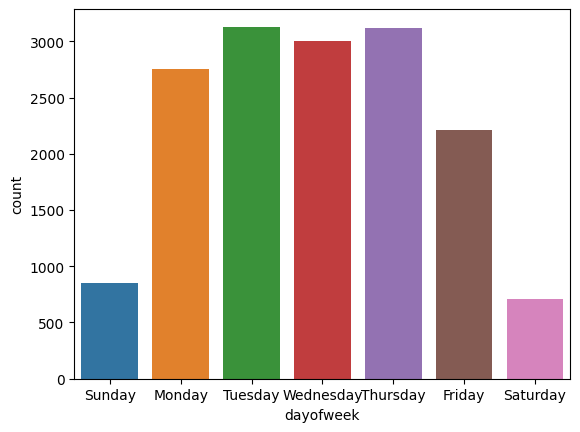

In [9]:
# checking out the days of the week. In a perfect scenaio all days would be equal. 1/7
sns.countplot(x='dayofweek', data=pv)

In [10]:
day_prob_table = pv['dayofweek'].value_counts(normalize=True)
day_prob_table

dayofweek
Tuesday      0.198264
Thursday     0.197821
Wednesday    0.190473
Monday       0.174447
Friday       0.140369
Sunday       0.053968
Saturday     0.044657
Name: proportion, dtype: float64

<Axes: xlabel='hour', ylabel='count'>

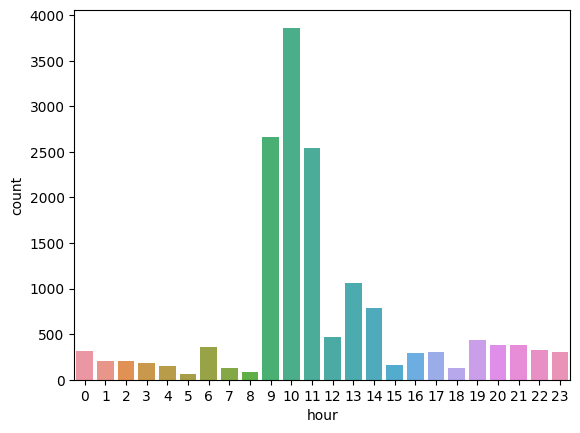

In [11]:
sns.countplot(x='hour', data=pv.sort_values("hour")) # Yuck let's sort it
# in a perfect scenairo all hours would be equal 1/24

In [12]:
hour_prob_table = pv['hour'].value_counts(normalize=True).sort_index()
hour_prob_table

hour
0     0.020143
1     0.013302
2     0.012922
3     0.011275
4     0.009755
5     0.003991
6     0.022677
7     0.008045
8     0.005701
9     0.168810
10    0.244632
11    0.160702
12    0.029645
13    0.067017
14    0.049661
15    0.010515
16    0.018243
17    0.019320
18    0.008171
19    0.027301
20    0.024324
21    0.024070
22    0.020460
23    0.019320
Name: proportion, dtype: float64

In [16]:
# example: retrieving a probability
hour = "02"
day = "Tuesday"
hour_prob_table[int(hour)], day_prob_table[day]

(0.012922024450497244, 0.19826439475517832)

## Main Program

Run the cells below this line to execute the main program. It assumes the `final_cuse_parking_violations.csv` exists already.

This should run on a new kernel provided `haversine` was installed.

In [5]:
from IPython.display import display, HTML, Image
from ipywidgets import interact_manual
import folium
import pandas as pd
import requests
from haversine import haversine, Unit

In [6]:
def geocode_syracuse_no_cache(location):
    '''
    This will geocode the location. It does not use a caching strategy
    '''
    location = f"{location} SYRACUSE, NY".upper()
    query_string = {'q': location, 'format': 'json'}
    headers = {"user-agent": "ist256 example mafudge"}
    url = 'https://nominatim.openstreetmap.org/search'
    response = requests.get(url, params=query_string, headers=headers)
    response.raise_for_status()
    geodata = response.json()
    if geodata != []:
        lat, lon = geodata[0]['lat'], geodata[0]['lon']
        return (lat, lon)
    else:
        return (0, 0)

assert geocode_syracuse_no_cache("330 W GENESEE ST") == ('43.05230228571428', '-76.15564457142858')

In [7]:
def mark_tickets_nearby(center_latlon, day, hour, pv, radius_in_miles):
    '''
    return a list of markers that are near center_latlon based on 
    radius_in_miles. was written to simplify the logic in the final program
    '''
    markers = []
    center_lat = float(center_latlon[0])
    center_lon = float(center_latlon[1])
    for index, row in pv[:].iterrows():
        lat = float(row['coords'].split(",")[0].replace("(","").replace("'","")) # clean up the lat which was a string
        lon = float(row['coords'].split(",")[1].replace(")","").replace("'","")) # # clean up the lon which was a string
        distance = haversine((center_lat, center_lon), (lat, lon), unit = Unit.MILES)
        if distance <= radius_in_miles:
            if day ==  row['dayofweek'] and hour == row['hour']:
                icon = icon=folium.Icon(color="red", icon="arrow-up")
            else:
                icon = icon=folium.Icon(color="orange", icon="arrow-up")

            text = f"{row['location']} - {row['dayofweek']} @ {row['hour']}:00 - {row['description']}"
            marker = folium.Marker(location=(lat, lon), popup = text, icon = icon)
            markers.append(marker)

    return markers

pv = pd.read_csv("final_cuse_parking_violations.csv")
lat, lon = geocode_syracuse_no_cache("330 W GENESEE ST")
assert len(mark_tickets_nearby((lat,lon), "Sunday", "09", pv, 0.05)) == 15

In [8]:
# Main Program
pv = pd.read_csv("final_cuse_parking_violations.csv")
day_prob_table = pv['dayofweek'].value_counts(normalize=True)
hour_prob_table = pv['hour'].value_counts(normalize=True).sort_index()
day_average = 1/7
hour_average = 1/24
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
hours = hour_prob_table.index.values
metered_parking_day_exception = ['Sunday']
metered_parking_hour_exception = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '19', '20', '21', '22', '23', '24']

display(HTML("<h1>Syracuse Parkmagic</h1>"))
display(HTML("Let us help you avoid a parking ticket!"))
display(HTML("Enter the day, hour and address of where you want to mark and we will do the rest!"))

@interact_manual(day=days, hour=hours, address="330 E WASHINGTON ST")
def onclick(day, hour, address):
    day_prob = day_prob_table[day]
    hour_prob = hour_prob_table[int(hour)]
    lat, lon = geocode_syracuse_no_cache(address)
    cusemap = folium.Map(location=(lat,lon), zoom_start=18)
    marker = folium.Marker(location=(lat, lon), popup=address, icon=folium.Icon(color="green", icon="home"))
    cusemap.add_child(marker, name=address)
    if day_prob > day_average:
        day_interval = "HIGHER"
    else:
        day_interval = "LOWER"
    if hour_prob > hour_average:
        hour_interval = "HIGHER"
    else:
        hour_interval = "LOWER"
    if hour in metered_parking_hour_exception or day in metered_parking_day_exception:
        meter = "You do NOT need to pay for metered parking."
    else:
        meter = "You must pay at a parking meter."

    display(HTML("<h3>Parking Analysis</h3>"))
    display(HTML(f"Report for {address} On {day} at {hour}:00"))
    display(HTML(f"<li>{100*day_prob:.1f}% of all tickets were issued on this day. This is {day_interval} than the average."))
    display(HTML(f"<li>{100*hour_prob:.1f}% of all tickets were issued at your selected hour. This is {hour_interval} than the average."))
    display(HTML(f"<li>{meter}"))

    display(HTML("<h4>Past Tickets Issued in This Area</h4>"))
    markers = mark_tickets_nearby((lat,lon),day, hour, pv, 0.1)
    for marker in markers:
        cusemap.add_child(marker)
    display(cusemap)


interactive(children=(Dropdown(description='day', options=('Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursd…